# Empirical Distribution Predictors

We may be losing a lot of information in the annotations by condensing them into a single number. Instead, we can train a model to predict the empirical distribution formed by the annotations over the answer choices. We do this by minimizing the cross-entropy between the predicted distributions and the empirical distributions. This is essentially softmax classification, but off-the-shelf implementations don't let you pass a distribution as a training label, so we have to roll our own in TensorFlow.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from ngram import *
from baselines import *

In [2]:
data_filename  = '../../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d = load_cf_labels(data_filename)
d = tidy_labels(d)
d = d.dropna(subset=['attack', 'aggression_score'])
d = d.iloc[np.random.permutation(np.arange(d.shape[0]))]

In [3]:
ngram_feature_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6), max_features = 15000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
])

In [4]:
training_epochs = 300
batch_size = 100
display_step = 20

# Attack Model: plurality labels

Fit a softmax regression to the most common annotation. 

In [5]:
labels = plurality(d['attack'])

data = get_labeled_comments(d, labels)
train, test = split(data, test_size = 0.2,)

y_train =train.ix[:, train.columns != 'x'].values[:,0]

y_test =test.ix[:, test.columns != 'x'].values[:,0]
y_train = np.array([y_train, 1- y_train]).T
y_test = np.array([y_test, 1- y_test]).T

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Epoch: 0001 cost= 8.204699506
Train Accuracy: 0.517008
Test Accuracy: 0.54955
Epoch: 0021 cost= 3.108355068
Train Accuracy: 0.732116
Test Accuracy: 0.698699
Epoch: 0041 cost= 1.315695496
Train Accuracy: 0.821411
Test Accuracy: 0.765766
Epoch: 0061 cost= 0.707351068
Train Accuracy: 0.853927
Test Accuracy: 0.806807
Epoch: 0081 cost= 0.513445991
Train Accuracy: 0.864932
Test Accuracy: 0.816817
Epoch: 0101 cost= 0.456074502
Train Accuracy: 0.873937
Test Accuracy: 0.826827
Epoch: 0121 cost= 0.440103314
Train Accuracy: 0.874687
Test Accuracy: 0.826827
Epoch: 0141 cost= 0.435699993
Train Accuracy: 0.875188
Test Accuracy: 0.826827
Epoch: 0161 cost= 0.434403535
Train Accuracy: 0.875938
Test Accuracy: 0.828829
Epoch: 0181 cost= 0.433971695
Train Accuracy: 0.876438
Test Accuracy: 0.82983
Epoch: 0201 cost= 0.433798511
Train Accuracy: 0.874937
Test Accuracy: 0.828829
Epoch: 0221 cost= 0.433704315
Train Accuracy: 0.877189
Test Accuracy: 0.82983
Epoch: 0241 cost= 0.433757910
Train Accuracy: 0.876188


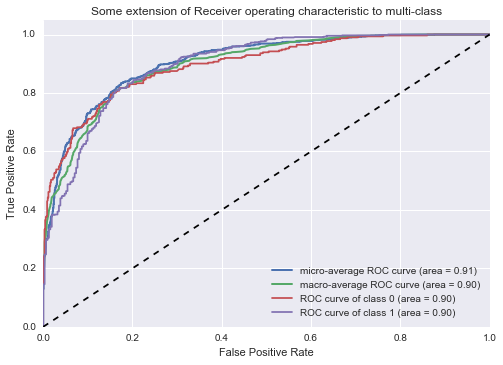

In [6]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

# Attack Model: empirical distribution labels
Fit a softmax regression to the empirical distribtion of annotions over answer choices.

In [7]:
labels = empirical_dist(d['attack'], w = 0.5)
data = get_labeled_comments(d, labels)
train, test = split(data, test_size = 0.2,)

y_train =train.ix[:, train.columns != 'x'].values
y_test =test.ix[:, train.columns != 'x'].values

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Epoch: 0001 cost= 8.205288506
Train Accuracy: 0.484242
Test Accuracy: 0.518519
Epoch: 0021 cost= 3.003493551
Train Accuracy: 0.732616
Test Accuracy: 0.732733
Epoch: 0041 cost= 1.295854561
Train Accuracy: 0.836918
Test Accuracy: 0.825826
Epoch: 0061 cost= 0.758935523
Train Accuracy: 0.864932
Test Accuracy: 0.841842
Epoch: 0081 cost= 0.605184676
Train Accuracy: 0.873687
Test Accuracy: 0.840841
Epoch: 0101 cost= 0.566653627
Train Accuracy: 0.875938
Test Accuracy: 0.83984
Epoch: 0121 cost= 0.558409962
Train Accuracy: 0.874937
Test Accuracy: 0.837838
Epoch: 0141 cost= 0.556913390
Train Accuracy: 0.874437
Test Accuracy: 0.837838
Epoch: 0161 cost= 0.556617055
Train Accuracy: 0.873937
Test Accuracy: 0.83984
Epoch: 0181 cost= 0.556591842
Train Accuracy: 0.874937
Test Accuracy: 0.83984
Epoch: 0201 cost= 0.556577343
Train Accuracy: 0.873937
Test Accuracy: 0.83984
Epoch: 0221 cost= 0.556570817
Train Accuracy: 0.875438
Test Accuracy: 0.83984
Epoch: 0241 cost= 0.556574699
Train Accuracy: 0.873937
Te

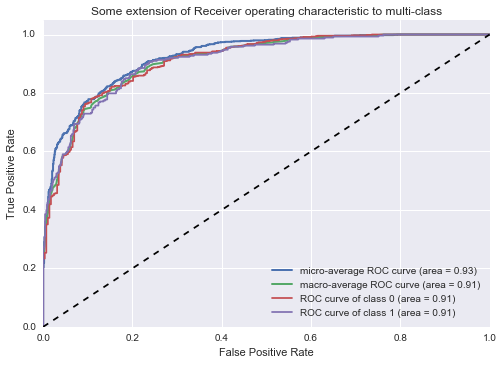

In [8]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

# Agression Model: plurality labels
Fit a softmax regression to the most common annotation. 

In [20]:
labels = plurality(d['aggression_score'])

data = get_labeled_comments(d, labels)
train, test = split(data, test_size = 0.2,)

m_train  = train.shape[0]
y_train = np.zeros((m_train, 7))
indices =  (train.ix[:, train.columns != 'x'].values[:,0] + 3).astype(int)
y_train[list(range(m_train)), indices] = 1


m_test  = test.shape[0]
y_test = np.zeros((m_test, 7))
indices =  (test.ix[:, test.columns != 'x'].values[:,0] + 3).astype(int)
y_test[list(range(m_test)), indices] = 1

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Epoch: 0001 cost= 27.162882159
Train Accuracy: 0.357429
Test Accuracy: 0.36036
Epoch: 0021 cost= 8.898848976
Train Accuracy: 0.688094
Test Accuracy: 0.686687
Epoch: 0041 cost= 3.245375244
Train Accuracy: 0.715108
Test Accuracy: 0.712713
Epoch: 0061 cost= 1.493684459
Train Accuracy: 0.723862
Test Accuracy: 0.71972
Epoch: 0081 cost= 0.984929957
Train Accuracy: 0.729365
Test Accuracy: 0.722723
Epoch: 0101 cost= 0.849817431
Train Accuracy: 0.732616
Test Accuracy: 0.723724
Epoch: 0121 cost= 0.816441604
Train Accuracy: 0.734117
Test Accuracy: 0.723724
Epoch: 0141 cost= 0.807941177
Train Accuracy: 0.735368
Test Accuracy: 0.724725
Epoch: 0161 cost= 0.805287913
Train Accuracy: 0.736618
Test Accuracy: 0.725726
Epoch: 0181 cost= 0.804289921
Train Accuracy: 0.736868
Test Accuracy: 0.726727
Epoch: 0201 cost= 0.803929287
Train Accuracy: 0.736618
Test Accuracy: 0.726727
Epoch: 0221 cost= 0.803671444
Train Accuracy: 0.737369
Test Accuracy: 0.726727
Epoch: 0241 cost= 0.803594630
Train Accuracy: 0.73736

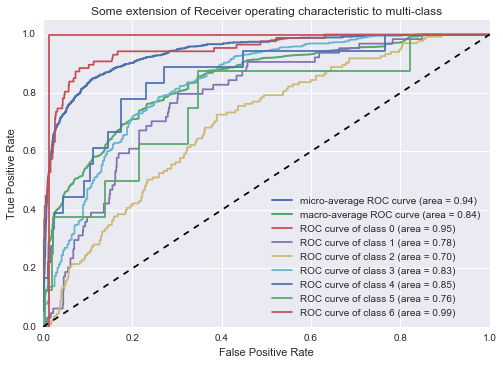

In [21]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)

# Agression Model: empirical distribution labels
Fit a softmax regression to the empirical distribtion of annotions over answer choices.

In [11]:
labels = empirical_dist(d['aggression_score'], w = 0.5)
data = get_labeled_comments(d, labels)
train, test = split(data, test_size = 0.2,)

y_train =train.ix[:, train.columns != 'x'].values
y_test =test.ix[:, train.columns != 'x'].values

ngram_feature_extractor = ngram_feature_pipeline.fit(train['x'])
X_train = ngram_feature_extractor.transform(train['x'])
X_test = ngram_feature_extractor.transform(test['x'])

Epoch: 0001 cost= 28.059797031
Train Accuracy: 0.136318
Test Accuracy: 0.13013
Epoch: 0021 cost= 9.434557464
Train Accuracy: 0.563031
Test Accuracy: 0.551552
Epoch: 0041 cost= 3.786415333
Train Accuracy: 0.6996
Test Accuracy: 0.696697
Epoch: 0061 cost= 2.083950337
Train Accuracy: 0.725113
Test Accuracy: 0.726727
Epoch: 0081 cost= 1.612181422
Train Accuracy: 0.725613
Test Accuracy: 0.727728
Epoch: 0101 cost= 1.497700070
Train Accuracy: 0.725613
Test Accuracy: 0.730731
Epoch: 0121 cost= 1.474369808
Train Accuracy: 0.725613
Test Accuracy: 0.730731
Epoch: 0141 cost= 1.470468318
Train Accuracy: 0.725863
Test Accuracy: 0.731732
Epoch: 0161 cost= 1.469893006
Train Accuracy: 0.726113
Test Accuracy: 0.731732
Epoch: 0181 cost= 1.469837735
Train Accuracy: 0.725863
Test Accuracy: 0.731732
Epoch: 0201 cost= 1.469856240
Train Accuracy: 0.725613
Test Accuracy: 0.730731
Epoch: 0221 cost= 1.469851768
Train Accuracy: 0.726613
Test Accuracy: 0.731732
Epoch: 0241 cost= 1.469869783
Train Accuracy: 0.725613

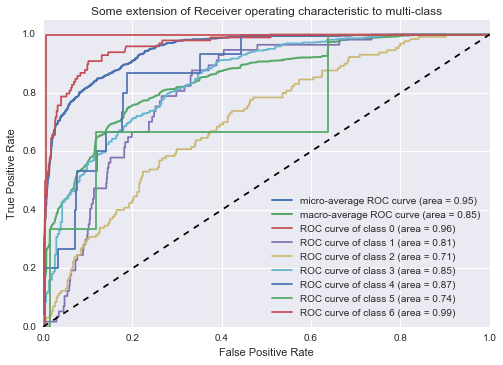

In [12]:
ED_CLF(X_train,
        y_train,
        X_test,
        y_test,
        training_epochs = training_epochs,
        batch_size = batch_size,
        display_step = display_step)